## ME2: Recreating a Pre-trained AlexNet on Numpy

Recreate torchvision AlexNet in Numpy. 

[AlexNet Weights Documentation](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html#torchvision.models.AlexNet_Weights)

Load the pre-trained weights and verify the results of 

acc@1 (on ImageNet-1K) 56.522

Submit the google colab link.

In [7]:
# AlexNet Pretrained Model Test on ImageNet-1K
import torch
from torchvision import models
from torchvision.models import AlexNet_Weights, alexnet
import torchvision
from torch.utils.data import DataLoader
import os
from PIL import Image
from torch.utils.data import Dataset

# Load pretrained AlexNet
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model.eval()

# Check available keys in the metadata
print("Available metadata keys:", AlexNet_Weights.IMAGENET1K_V1.meta.keys())

# Use an existing key or handle the missing key
acc1 = AlexNet_Weights.IMAGENET1K_V1.meta.get("_metrics", "Key not found")
print(f"AlexNet Top-1 Accuracy on ImageNet-1K: {acc1}")

Available metadata keys: dict_keys(['num_params', 'min_size', 'categories', 'recipe', '_metrics', '_ops', '_file_size', '_docs'])
AlexNet Top-1 Accuracy on ImageNet-1K: {'ImageNet-1K': {'acc@1': 56.522, 'acc@5': 79.066}}


### Creating the ImageNetValDataset(Dataset)
This section defines the `ImageNetValDataset` class, a custom PyTorch dataset for loading and preprocessing the ImageNet validation dataset. It handles image-label pairing, applies transformations, and ensures data consistency.

In [8]:

class ImageNetValDataset(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # Load labels
        with open(label_file, "r") as f:
            self.labels = [int(line.strip().split()[1]) for line in f.readlines()]
        
        # Assume images are in alphabetical order (ILSVRC2012 convention: ILSVRC2012_val_00000001.JPEG ...)
        self.img_files = sorted(os.listdir(img_dir))
        assert len(self.img_files) == len(self.labels), "Mismatch between images and labels"

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

### Loading the validation data, and validation data labels  
The cell code below will throw an error if incorrect path is supplied in `val_img_dir` and `val_label_file`

In [22]:

weights = AlexNet_Weights.IMAGENET1K_V1

transform = weights.transforms()

# REPLACE, Path setup
val_img_dir = "./data/mp2/ILSVRC2012_img_val"          # REPLACE, directory with all 50k images
val_label_file = "./data/mp2/val.txt"  #REPLACE, file with 50k labels (one per line)
# Dataset + Loader


val_dataset = ImageNetValDataset(val_img_dir, val_label_file, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

### conv2d, relu, flatten, max_pool2d

This section provides the implementation of fundamental building blocks for a neural network in NumPy. These include:

- **conv2d**: Performs 2D convolution on input data using a specified kernel.
- **relu**: Applies the ReLU activation function, setting all negative values to zero.
- **flatten**: Reshapes the input into a 2D array, typically used before fully connected layers.
- **max_pool2d**: Implements max pooling, reducing the spatial dimensions of the input while retaining the most significant features.

In [16]:
import numpy as np
from typing import Union, Tuple
import torch
import torch.nn.functional as F
from einops import rearrange, reduce


def conv2d(input, weight, bias, stride=1, padding=0):
    # Add padding to the input
    if padding > 0:
        input = np.pad(input, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    
    # Extract dimensions
    batch_size, in_channels, in_height, in_width = input.shape
    out_channels, _, kernel_height, kernel_width = weight.shape
    
    # Calculate output dimensions
    out_height = (in_height - kernel_height) // stride + 1
    out_width = (in_width - kernel_width) // stride + 1
    
    # Extract image patches using stride tricks
    shape = (batch_size, in_channels, out_height, out_width, kernel_height, kernel_width)
    strides = (input.strides[0], input.strides[1], stride * input.strides[2], 
               stride * input.strides[3], input.strides[2], input.strides[3])
    
    patches = np.lib.stride_tricks.as_strided(input, shape=shape, strides=strides)
    
    # Perform convolution using einsum
    # einsum pattern: batch, out_h, out_w, in_ch, kh, kw × out_ch, in_ch, kh, kw -> batch, out_ch, out_h, out_w
    output = np.einsum('bcHWij,ocij->boHW', patches, weight, optimize=True)
    # Add bias
    output += bias.reshape(1, out_channels, 1, 1)
    
    return output

def relu(input):
    return np.maximum(0, input)


def flatten(input):
    return input.reshape(input.shape[0], -1)

def linear(input, weight, bias):
    return np.dot(input, weight.T) + bias



def _pair(x: Union[int, Tuple[int,int]]) -> Tuple[int,int]:
    if isinstance(x, int):
        return (x, x)
    if isinstance(x, tuple) and len(x) == 2:
        return x
    raise ValueError("kernel_size/stride must be int or tuple of two ints")


def max_pool2d(input: np.ndarray, 
               kernel_size: Union[int, Tuple[int,int]],
               stride: Union[int, Tuple[int,int]] = None) -> np.ndarray:
    """
    Max pooling implemented using einops and numpy strided operations.
    Input/Output are numpy arrays.

    Args:
        input: numpy array of shape (N, C, H, W)
        kernel_size: int or (kh, kw)
        stride: int or (sh, sw). If None, defaults to kernel_size.

    Returns:
        numpy array of shape (N, C, H_out, W_out)
    """
    if input.ndim != 4:
        raise ValueError("input must be a 4D array (N, C, H, W)")

    kh, kw = _pair(kernel_size)
    if stride is None:
        sh, sw = kh, kw
    else:
        sh, sw = _pair(stride)

    N, C, H, W = input.shape
    
    # Compute output spatial dimensions
    H_out = (H - kh) // sh + 1
    W_out = (W - kw) // sw + 1
    
    # Create sliding windows using numpy's stride_tricks
    shape = (N, C, H_out, W_out, kh, kw)
    strides = (
        input.strides[0],  # N stride
        input.strides[1],  # C stride
        sh * input.strides[2],  # H stride
        sw * input.strides[3],  # W stride
        input.strides[2],  # kh stride (within window)
        input.strides[3]   # kw stride (within window)
    )
    
    # Extract sliding windows
    windows = np.lib.stride_tricks.as_strided(
        input, 
        shape=shape, 
        strides=strides,
        writeable=False  # Prevent accidental modification
    )
    
    # Rearrange and apply max pooling
    windows_rearranged = rearrange(windows, 'n c h w kh kw -> n c h w (kh kw)')
    output = reduce(windows_rearranged, 'n c h w k -> n c h w', 'max')
    
    return output

### AlexNetNumpy

This section introduces the `AlexNetNumpy` class, a NumPy-based implementation of the AlexNet architecture. It replicates the forward pass of the pre-trained AlexNet model using NumPy operations, including convolution, ReLU activation, max pooling, and fully connected layers. The class is designed to process input data and produce predictions similar to the PyTorch AlexNet model.

In [17]:

class AlexNetNumpy:
    def __init__(self, weights):
        self.weights = weights

    def forward(self, x):
        # Layer 1: Convolution + ReLU + Max Pooling
        x = conv2d(x, self.weights['features.0.weight'], self.weights['features.0.bias'], stride=4, padding=2)  # Expected shape: (1, 64, 55, 55)
        x = relu(x)  # Expected shape: (1, 64, 55, 55)
        x = max_pool2d(x, kernel_size=3, stride=2)  # Expected shape: (1, 64, 27, 27)

        # Layer 2: Convolution + ReLU + Max Pooling
        x = conv2d(x, self.weights['features.3.weight'], self.weights['features.3.bias'], stride=1, padding=2)  # Expected shape: (1, 192, 27, 27)
        x = relu(x)  # Expected shape: (1, 192, 27, 27)
        x = max_pool2d(x, kernel_size=3, stride=2)  # Expected shape: (1, 192, 13, 13)

        # Layer 3: Convolution + ReLU
        x = conv2d(x, self.weights['features.6.weight'], self.weights['features.6.bias'], stride=1, padding=1)  # Expected shape: (1, 384, 13, 13)
        x = relu(x)  # Expected shape: (1, 384, 13, 13)

        # Layer 4: Convolution + ReLU
        x = conv2d(x, self.weights['features.8.weight'], self.weights['features.8.bias'], stride=1, padding=1)  # Expected shape: (1, 256, 13, 13)
        x = relu(x)  # Expected shape: (1, 256, 13, 13)

        # Layer 5: Convolution + ReLU + Max Pooling
        x = conv2d(x, self.weights['features.10.weight'], self.weights['features.10.bias'], stride=1, padding=1)  # Expected shape: (1, 256, 13, 13)
        x = relu(x)  # Expected shape: (1, 256, 13, 13)
        x = max_pool2d(x, kernel_size=3, stride=2)  # Expected shape: (1, 256, 6, 6)

        # Flatten
        x = flatten(x)

        # Fully Connected Layer 1 + ReLU
        x = linear(x, self.weights['classifier.1.weight'], self.weights['classifier.1.bias'])
        x = relu(x)

        # Fully Connected Layer 2 + ReLU
        x = linear(x, self.weights['classifier.4.weight'], self.weights['classifier.4.bias'])
        x = relu(x)

        # Fully Connected Layer 3 (Output Layer)
        x = linear(x, self.weights['classifier.6.weight'], self.weights['classifier.6.bias'])

        return x


In [31]:
# Initialize AlexNetNumpy with pretrained weights
weights_and_biases = {}
model = torchvision.models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
for name, param in model.named_parameters():
    weights_and_biases[name] = param.detach().numpy()


numpy_alexnet = AlexNetNumpy(weights_and_biases)

### Evalaute model's accuracy on Validation dataset


In [24]:
import tqdm

correct_top1 = 0
correct_top5 = 0
total = 0

alexnet_top1 = 0
alexnet_top5 = 0

for images, labels in tqdm.tqdm(val_loader):
    # Convert to numpy array
    numpy_output = numpy_alexnet.forward(images)
    
    pred_top1 = numpy_output.argsort(axis=1)[:, -1:][:, ::-1]  # Top-1 prediction
    pred_top5 = numpy_output.argsort(axis=1)[:, -5:][:, ::-1]  # Top-5 predictions
    


    total += labels.size(0)
    correct_top1 += (pred_top1.squeeze() == labels).sum().item()
    correct_top5 += sum([labels[i].item() in pred_top5[i] for i in range(labels.size(0))])



100%|██████████| 782/782 [21:23<00:00,  1.64s/it]


### Accuracy of Numpy-AlexNet on Validation Set

In [25]:
if total == 0:
    raise ValueError("Total number of samples is zero, cannot compute accuracy.")
acc1 = 100 * correct_top1 / total
acc5 = 100 * correct_top5 / total
print("Accuracy of NumPy AlexNet on Validation Set:")
print(f"Top-1 Accuracy: {acc1:.3f}%")
print(f"Top-5 Accuracy: {acc5:.3f}%")

print("Accuracy of PyTorch AlexNet on Validation Set:")
print(f"Top-1 Accuracy: {weights.meta['_metrics']['ImageNet-1K']['acc@1']:.3f}%")
print(f"Top-5 Accuracy: {weights.meta['_metrics']['ImageNet-1K']['acc@5']:.3f}%")

Accuracy of NumPy AlexNet on Validation Set:
Top-1 Accuracy: 56.556%
Top-5 Accuracy: 79.084%
Accuracy of PyTorch AlexNet on Validation Set:
Top-1 Accuracy: 56.522%
Top-5 Accuracy: 79.066%


Actual Label: laptop, Predicted Label: notebook


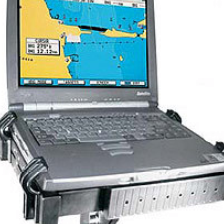

Actual Label: espresso maker, Predicted Label: espresso maker


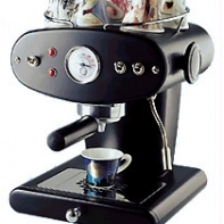

Actual Label: envelope, Predicted Label: envelope


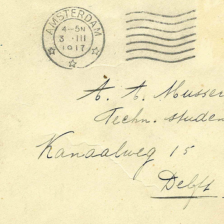

Actual Label: boxer, Predicted Label: pug


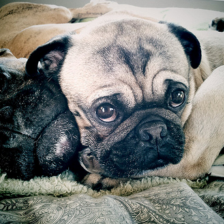

Actual Label: binder, Predicted Label: rule


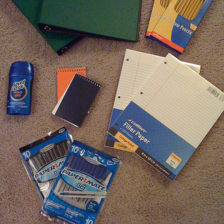

Actual Label: paddle, Predicted Label: ice bear


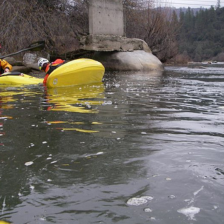

Actual Label: langur, Predicted Label: langur


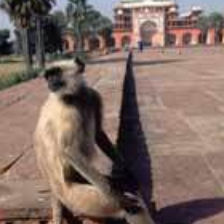

Actual Label: dingo, Predicted Label: dingo


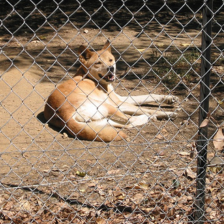

Actual Label: chain saw, Predicted Label: chain saw


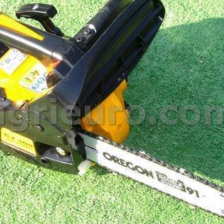

Actual Label: bookshop, Predicted Label: confectionery


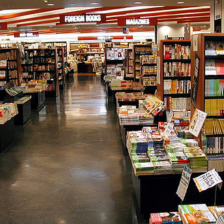

In [34]:
import random
from torchvision.transforms.functional import to_pil_image
from einops import rearrange

# Select 5 random indices
random_indices = random.sample(range(len(val_dataset)), 10)
categories = weights.meta.get('categories')
# Display and print labels for the selected images
for idx in random_indices:
    image, label = val_dataset[idx]
    numpy_output = numpy_alexnet.forward(rearrange(image, "c h w -> 1 c h w"))
    pred = numpy_output.argsort(axis=1)[:, -1:][:, ::-1]
    print(f"Actual Label: {categories[label]}, Predicted Label: {categories[rearrange(pred, '1 1 -> 1')[0]]}")
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    denormalized_image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)

    # Display the denormalized image
    display(to_pil_image(denormalized_image))